In [ ]:
!pip install fastai

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from fastai.tabular.all import *
from sklearn.preprocessing import StandardScaler
import fastai
from sklearn.model_selection import train_test_split
from fastai.tabular.all import *


In [ ]:
drive.mount('/content/drive')
csv_path = "drive/MyDrive/engine-data.csv"
model_path = "drive/MyDrive/engine-data-model.pth"


#csv_path = "/content/engine-data.csv"
#model_path = "/content/engine-data-model.pth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_columns = [
    'MAIN LO INLET PRESS LOW (bar)',
    'ME AIR COOLER CW INLET PRESS LOW (bar)',
    'ME FO CONSUMPTION (t/d)',
    'ME FO FLOW COUNTER',
    'ME FO FLOWMETER INLET TEMP',
    'ME FO INLET PRESS LOW (bar)',
    'ME FO INLET TEMP',
    'ME FO INLET VISCOSITY & HIGH-LOW (cSt)',
    'ME FO MASS FLOW (kg/h)',
    'ME JCFW INLET PRESS INDICATION (bar)',
    'ME JCFW INLET PRESS LOW (bar)',
    'ME PCO INLET PRESS LOW (bar)',
    'ME SCAV AIR INLET PRESS (bar)',
    'ME STARTING AIR INLET PRESS LOW (bar)',
    'ME 1 AIR COOLER CW INLET TEMP',
    'ME 2 AIR COOLER CW INLET TEMP',
    'ME 3 AIR COOLER CW INLET TEMP'
]

output_columns = [
    'ME SHAFT POWER',
    'ME SHAFT TORQUE'
]



In [ ]:
df = pd.read_csv(csv_path)
# df = df.fillna(0.0)
df = df.fillna(df.mean())
df.head()


,MAIN LO INLET PRESS LOW (bar),ME AIR COOLER CW INLET PRESS LOW (bar),ME FO CONSUMPTION (t/d),ME FO FLOW COUNTER,ME FO FLOWMETER INLET TEMP,ME FO INLET PRESS LOW (bar),ME FO INLET TEMP,ME FO INLET VISCOSITY & HIGH-LOW (cSt),ME FO MASS FLOW (kg/h),ME JCFW INLET PRESS INDICATION (bar),ME JCFW INLET PRESS LOW (bar),ME PCO INLET PRESS LOW (bar),ME SCAV AIR INLET PRESS (bar),ME STARTING AIR INLET PRESS LOW (bar),ME 1 AIR COOLER CW INLET TEMP,ME 2 AIR COOLER CW INLET TEMP,ME 3 AIR COOLER CW INLET TEMP,ME SHAFT POWER,ME SHAFT TORQUE
0,2.60,3.73,0.84,36.0,83.0,7.56,136.8,11.7,34.82,4.82,4.85,2.58,0.00,26.560000,36.2,35.8,35.300000,0,-31
1,2.45,4.19,91.06,3960.0,97.5,7.23,139.6,11.9,3794.18,4.87,4.87,2.42,0.89,25.420000,36.3,35.9,35.092974,19700,2937
2,2.63,3.63,0.00,0.0,91.8,7.60,106.7,11.8,0.00,4.68,4.72,2.61,0.01,26.269934,35.9,35.5,35.200000,0,-40
3,2.45,4.14,82.07,3564.0,95.4,7.26,138.9,11.7,3419.47,4.81,4.81,2.42,0.69,25.630000,36.4,36.0,35.600000,17780,2745
4,2.55,3.65,82.44,3564.0,98.7,7.24,141.3,12.3,3435.01,4.69,4.69,2.52,0.70,24.810000,35.8,35.4,35.100000,18050,2801


In [ ]:
input_columns_values = df[input_columns].values
output_columns_values = df[output_columns].values
print(input_columns)
print(output_columns)

['MAIN LO INLET PRESS LOW (bar)', 'ME AIR COOLER CW INLET PRESS LOW (bar)', 'ME FO CONSUMPTION (t/d)', 'ME FO FLOW COUNTER', 'ME FO FLOWMETER INLET TEMP', 'ME FO INLET PRESS LOW (bar)', 'ME FO INLET TEMP', 'ME FO INLET VISCOSITY & HIGH-LOW (cSt)', 'ME FO MASS FLOW (kg/h)', 'ME JCFW INLET PRESS INDICATION (bar)', 'ME JCFW INLET PRESS LOW (bar)', 'ME PCO INLET PRESS LOW (bar)', 'ME SCAV AIR INLET PRESS (bar)', 'ME STARTING AIR INLET PRESS LOW (bar)', 'ME 1 AIR COOLER CW INLET TEMP', 'ME 2 AIR COOLER CW INLET TEMP', 'ME 3 AIR COOLER CW INLET TEMP']
['ME SHAFT POWER', 'ME SHAFT TORQUE']


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [ ]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(train_df))

In [ ]:
to = TabularPandas(train_df, procs=[ Categorify, FillMissing, Normalize],
                   cat_names = [],
                   cont_names = input_columns,
                   y_names= output_columns,
                   splits=splits)
dls = to.dataloaders(bs=64)


In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_1 = nn.Linear(17,34)
    self.relu_1 = nn.ReLU()
    self.linear_2 = nn.Linear(34,17)
    self.relu_2 = nn.ReLU()
    self.linear_3 = nn.Linear(17,2)

  def forward(self, x_cat, x_cont):
    x = self.linear_1(x_cont)
    x = self.relu_1(x)
    x = self.linear_2(x)
    x = self.relu_2(x)
    x = self.linear_3(x)
    return x
model = NeuralNetwork().to(device)

In [ ]:
dls.show_batch()

,MAIN LO INLET PRESS LOW (bar),ME AIR COOLER CW INLET PRESS LOW (bar),ME FO CONSUMPTION (t/d),ME FO FLOW COUNTER,ME FO FLOWMETER INLET TEMP,ME FO INLET PRESS LOW (bar),ME FO INLET TEMP,ME FO INLET VISCOSITY & HIGH-LOW (cSt),ME FO MASS FLOW (kg/h),ME JCFW INLET PRESS INDICATION (bar),ME JCFW INLET PRESS LOW (bar),ME PCO INLET PRESS LOW (bar),ME SCAV AIR INLET PRESS (bar),ME STARTING AIR INLET PRESS LOW (bar),ME 1 AIR COOLER CW INLET TEMP,ME 2 AIR COOLER CW INLET TEMP,ME 3 AIR COOLER CW INLET TEMP,ME SHAFT POWER,ME SHAFT TORQUE
0,2.46,4.020000,55.811348,3492.0,95.199997,7.27,137.600006,12.0,3350.830078,4.81,4.81,2.43,0.670000,27.639999,36.299999,35.900002,35.500000,17690.0,2727.0
1,2.62,3.781279,0.000000,0.0,86.800003,7.57,131.000000,11.9,0.000000,4.59,4.60,2.60,0.010000,26.420000,35.700001,35.400002,35.000000,0.0,-44.0
2,2.49,3.860000,76.430000,3528.0,96.900002,7.31,129.800003,12.0,3184.379883,4.84,4.84,2.46,0.630000,26.260000,35.900002,35.500000,35.099998,17580.0,2761.0
3,2.61,3.630000,0.000000,0.0,88.500000,7.56,132.399994,11.5,0.000000,4.78,4.78,2.59,0.020000,26.549999,35.599998,35.200001,34.799999,0.0,-41.0
4,2.61,3.630000,0.770000,36.0,93.800003,7.56,113.500000,11.7,32.260010,4.75,4.74,2.58,0.000000,26.000000,35.900002,35.500000,35.099998,0.0,-8.0
5,2.48,3.840000,77.389999,3564.0,93.500000,7.26,131.899994,11.6,3224.510010,4.84,4.84,2.45,0.497028,27.650000,36.500000,36.099998,35.700001,17830.0,2798.0
6,2.55,3.690000,130.419998,6156.0,99.199997,7.14,113.000000,11.8,5433.970215,4.45,4.45,2.52,1.660000,27.830000,35.900002,35.500000,35.200001,29720.0,3951.0
7,2.62,3.640000,0.000000,0.0,89.800003,8.07,114.500000,11.5,0.000000,4.81,4.81,2.60,0.020000,26.269934,36.299999,35.900002,35.599998,0.0,-46.0
8,2.58,3.740000,0.000000,0.0,94.300003,7.59,111.800003,12.2,0.000000,4.47,4.49,2.54,0.070000,27.230000,35.900002,35.599998,35.200001,0.0,-18.0
9,2.54,3.730000,76.400002,3528.0,97.300003,7.31,130.899994,12.0,2331.462891,4.48,4.48,2.52,0.497028,26.139999,36.000000,35.453377,35.299999,17280.0,2755.0


SuggestedLRs(valley=0.3630780577659607)

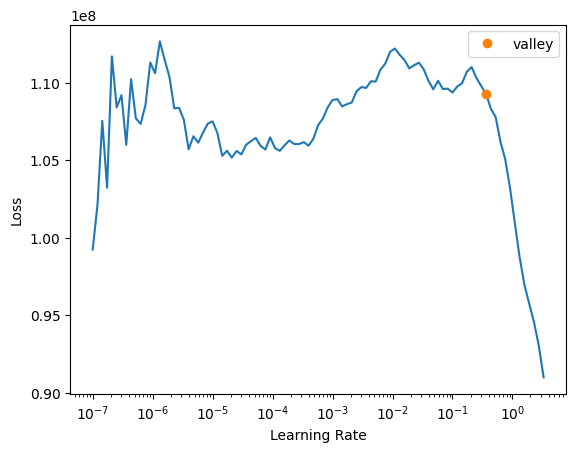

In [ ]:
learn = tabular_learner(dls)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, lr_max=0.5)

epoch,train_loss,valid_loss,time
0,98646272.000000,125780664.000000,00:00


In [ ]:
learn.show_results()

,MAIN LO INLET PRESS LOW (bar),ME AIR COOLER CW INLET PRESS LOW (bar),ME FO CONSUMPTION (t/d),ME FO FLOW COUNTER,ME FO FLOWMETER INLET TEMP,ME FO INLET PRESS LOW (bar),ME FO INLET TEMP,ME FO INLET VISCOSITY & HIGH-LOW (cSt),ME FO MASS FLOW (kg/h),ME JCFW INLET PRESS INDICATION (bar),ME JCFW INLET PRESS LOW (bar),ME PCO INLET PRESS LOW (bar),ME SCAV AIR INLET PRESS (bar),ME STARTING AIR INLET PRESS LOW (bar),ME 1 AIR COOLER CW INLET TEMP,ME 2 AIR COOLER CW INLET TEMP,ME 3 AIR COOLER CW INLET TEMP,ME SHAFT POWER,ME SHAFT TORQUE,ME SHAFT POWER_pred,ME SHAFT TORQUE_pred
0,0.062990,2.215427,0.525889,0.630410,0.205747,-0.162840,-1.478699,-0.123609,0.526457,-0.228573,-0.144565,0.024556,0.793105,0.069051,-0.296973,-0.336102,-0.415118,20680.0,3036.0,614.752625,597.327087
1,-0.015729,1.132070,0.727232,0.735351,-0.058499,0.037862,1.125743,-0.932147,0.727536,0.831057,0.834575,-0.020422,1.254330,0.463459,3.573884,3.485751,3.352523,23310.0,3381.0,653.319214,634.369385
2,0.003951,2.386485,0.446078,0.446764,0.520811,-0.153761,0.964405,-0.123609,0.446831,0.912569,0.916172,-0.020422,0.532413,0.049330,0.841514,0.787972,0.693013,18570.0,2850.0,606.022644,589.032410
3,0.259788,0.789957,-0.830758,-0.891227,-0.444707,0.127701,0.418932,0.145903,-0.828123,-0.880651,-0.960515,0.271939,-0.951528,0.236675,0.613811,0.563160,0.693013,0.0,16.0,-1133.775635,-1110.455933
4,0.338508,-0.692533,-0.842548,-0.904345,-0.546340,0.045986,0.887578,0.145903,-0.839965,0.994077,0.997765,0.047929,-0.931475,-1.025433,-0.524676,-0.560914,-0.636750,0.0,-43.0,-1171.848145,-1147.724487
5,0.003951,1.075051,0.470716,0.472999,0.571627,-0.153761,0.979770,-0.258366,0.471388,1.075589,1.079362,-0.042912,0.612626,0.650804,-0.069279,-0.111282,-0.193495,19470.0,2940.0,614.551086,597.305603
6,0.161389,-0.065326,0.209968,0.197530,0.287054,-0.044808,0.756972,-0.002153,0.211048,0.831057,0.834575,0.137003,0.251667,1.193115,0.158423,0.113529,0.028128,14410.0,2493.0,454.575623,442.584717
7,0.161389,-0.236383,0.277385,0.341824,0.429341,0.000589,0.488077,-0.258366,0.278335,-2.021789,-2.021253,0.159492,0.311827,-1.183196,0.158423,0.338341,0.249759,16990.0,2692.0,533.384827,519.139893
8,0.358187,-0.920610,0.001087,-0.851875,0.134604,0.218495,0.733924,0.280658,-0.789866,0.831057,0.834575,0.047929,-0.831209,-2.908734,-0.524676,-0.560914,-0.636750,220.0,164.0,-881.085022,-863.397888


In [ ]:
learn.fit_one_cycle(50, lr_max=0.5)

epoch,train_loss,valid_loss,time
0,97914632.000000,125085736.000000,00:00
1,103379808.000000,122638192.000000,00:00
2,101270136.000000,118830328.000000,00:00
3,101163696.000000,111093128.000000,00:00
4,98776952.000000,90979576.000000,00:00
5,90977280.000000,58016092.000000,00:00
6,84159440.000000,26284800.000000,00:00
7,71460528.000000,44347032.000000,00:00
8,59723052.000000,109156960.000000,00:00
9,50693924.000000,47050456.000000,00:00


In [ ]:
learn.show_results()

,MAIN LO INLET PRESS LOW (bar),ME AIR COOLER CW INLET PRESS LOW (bar),ME FO CONSUMPTION (t/d),ME FO FLOW COUNTER,ME FO FLOWMETER INLET TEMP,ME FO INLET PRESS LOW (bar),ME FO INLET TEMP,ME FO INLET VISCOSITY & HIGH-LOW (cSt),ME FO MASS FLOW (kg/h),ME JCFW INLET PRESS INDICATION (bar),ME JCFW INLET PRESS LOW (bar),ME PCO INLET PRESS LOW (bar),ME SCAV AIR INLET PRESS (bar),ME STARTING AIR INLET PRESS LOW (bar),ME 1 AIR COOLER CW INLET TEMP,ME 2 AIR COOLER CW INLET TEMP,ME 3 AIR COOLER CW INLET TEMP,ME SHAFT POWER,ME SHAFT TORQUE,ME SHAFT POWER_pred,ME SHAFT TORQUE_pred
0,-0.015729,2.272448,0.534656,0.538587,0.409014,-0.190079,0.987453,-0.527878,0.535277,0.994077,0.997765,-0.065401,0.833212,-0.946551,3.346182,3.260940,3.352523,21670.0,3261.0,20018.257812,2920.399902
1,0.338508,-0.863591,-0.842548,-0.904345,-1.999697,0.073225,0.749289,0.550171,-0.839965,0.749549,0.671385,0.384386,0.025121,-1.252217,-0.524676,-0.560914,-0.636750,10.0,-55.0,4904.162109,768.010742
2,0.062990,2.329465,0.758673,0.892761,0.307381,-0.199158,-1.524795,0.280658,0.758907,-0.065553,-0.062972,0.024556,1.314490,-0.690186,-0.069279,-0.111282,0.028128,23400.0,3348.0,22106.277344,3115.106934
3,0.299148,-0.464458,-0.842548,-0.904345,-0.698790,0.236654,1.087329,-0.393123,-0.839965,0.831057,0.752982,0.316918,-0.851262,1.143815,0.386117,0.563160,0.471382,0.0,0.0,1432.320679,272.158813
4,0.082670,0.390824,0.758069,0.879644,0.673261,-0.208238,0.319057,0.550171,0.758287,-0.880651,-0.878922,0.069535,1.494969,1.242415,0.158423,-0.111282,0.028128,24790.0,3524.0,23018.535156,3258.371094
5,0.240109,0.504862,-0.842548,-0.904345,-1.074833,0.136781,-0.987005,0.145903,-0.839965,-0.147061,-0.144565,0.249450,-0.971582,0.709965,0.841514,0.787972,0.693013,0.0,-27.0,-84.786194,-16.236723
6,0.358187,-0.692533,-0.842548,-0.904345,-0.983363,3.269181,-0.856399,-0.123609,-0.839965,-1.695750,-1.694872,0.361897,-0.951528,0.828286,-0.296973,-0.111282,-0.193495,0.0,-37.0,267.949951,150.822998
7,0.082670,0.219768,0.592399,0.735351,0.571627,0.391004,-1.386506,-0.123609,0.592889,0.260486,0.263408,0.024556,1.033744,-1.025433,-0.524676,-0.336102,-0.415118,21220.0,3086.0,20184.093750,2990.835205
8,0.181069,-0.521477,1.164231,1.325641,0.673261,0.037862,-1.010053,0.145903,1.163838,-2.103301,-2.102849,0.159492,2.397366,-1.271938,-0.524676,-0.560914,-0.415118,27920.0,3675.0,27504.117188,3688.664307


In [ ]:
learn.fit_one_cycle(50, lr_max=0.5)

epoch,train_loss,valid_loss,time
0,1210506.000000,1186325.625000,00:00
1,1222940.750000,1430285.500000,00:00
2,1371378.625000,1621501.875000,00:00
3,1312135.750000,1611765.875000,00:00
4,1249352.375000,1991749.750000,00:00
5,1450920.125000,1905841.000000,00:00
6,1383060.125000,821921.625000,00:00
7,1256688.125000,1542941.250000,00:00
8,1468727.000000,2681425.500000,00:00
9,1389015.750000,10463543.000000,00:00


In [ ]:
learn.show_results()

,MAIN LO INLET PRESS LOW (bar),ME AIR COOLER CW INLET PRESS LOW (bar),ME FO CONSUMPTION (t/d),ME FO FLOW COUNTER,ME FO FLOWMETER INLET TEMP,ME FO INLET PRESS LOW (bar),ME FO INLET TEMP,ME FO INLET VISCOSITY & HIGH-LOW (cSt),ME FO MASS FLOW (kg/h),ME JCFW INLET PRESS INDICATION (bar),ME JCFW INLET PRESS LOW (bar),ME PCO INLET PRESS LOW (bar),ME SCAV AIR INLET PRESS (bar),ME STARTING AIR INLET PRESS LOW (bar),ME 1 AIR COOLER CW INLET TEMP,ME 2 AIR COOLER CW INLET TEMP,ME 3 AIR COOLER CW INLET TEMP,ME SHAFT POWER,ME SHAFT TORQUE,ME SHAFT POWER_pred,ME SHAFT TORQUE_pred
0,0.259788,-0.692533,-0.164905,-0.143526,0.368361,0.082304,-1.432602,-0.258366,-0.163356,0.260486,0.263408,0.249450,-0.490303,-1.518444,0.613811,0.563160,0.693013,8070.0,1625.0,7816.916992,1549.089966
1,0.200749,-0.578496,0.315779,0.381176,0.043134,-0.053887,0.518807,-0.002153,0.316708,-0.717632,-0.878922,0.181982,0.025121,-1.459283,-0.524676,-0.560914,-0.415118,17370.0,2702.0,14101.520508,2502.680176
2,0.240109,1.531202,-0.842548,-0.904345,-0.465033,0.236654,0.495759,-0.393123,-0.839965,-0.880651,-0.960515,0.226960,-0.951528,0.059191,0.841514,0.787972,0.693013,0.0,-44.0,781.864502,114.957947
3,0.338508,-0.806571,-0.830607,0.013222,-0.566666,0.127701,0.418932,0.011146,-0.828112,-0.880651,-1.123705,0.361897,-0.971582,1.094512,-0.980064,-1.010545,-0.858373,0.0,-46.0,1718.451050,307.483978
4,0.082670,1.189089,0.745522,0.879644,0.439504,-0.180999,0.088575,0.011146,0.004601,-1.369710,-1.368492,0.024556,1.374650,-0.650746,0.386117,0.338341,0.471382,23870.0,3377.0,21133.189453,3058.149902
5,0.062990,1.132070,0.459833,0.459882,0.388688,-0.144681,0.403567,0.415415,0.460433,1.075589,0.752982,0.024556,0.452200,0.729686,-0.069279,0.113529,0.028128,18600.0,2881.0,17841.205078,2859.607666
6,0.436907,-1.148685,-0.842548,-0.891227,0.205747,0.136781,-0.833351,-0.662635,-0.839965,0.341998,0.345005,0.474344,-0.851262,-1.281799,2.207695,2.361677,2.244391,1290.0,1065.0,1712.937622,354.352936
7,0.240109,0.504862,-0.842548,-0.904345,-1.074833,0.136781,-0.987005,0.145903,-0.839965,-0.147061,-0.144565,0.249450,-0.971582,0.709965,0.841514,0.787972,0.693013,0.0,-27.0,630.233704,111.291336
8,0.122030,0.105730,0.503518,0.591057,0.195584,-0.190079,0.372836,0.415415,0.504149,-1.125179,-1.123705,0.092024,0.793105,0.640944,-0.069279,-0.111282,-0.193495,20450.0,3053.0,19251.078125,3012.445312


In [ ]:
learn.fit_one_cycle(500, lr_max=0.5)

epoch,train_loss,valid_loss,time
0,2395903.750000,1567760.750000,00:00
1,1678705.250000,1478974.750000,00:00
2,1613171.875000,1276021.250000,00:00
3,1494304.000000,1412236.125000,00:00
4,1534837.000000,1484119.625000,00:00
5,1513216.250000,1830292.500000,00:00
6,1366128.750000,1769382.500000,00:00
7,1332010.500000,1456189.000000,00:00
8,1286583.250000,1700276.000000,00:00
9,1320050.750000,2231972.500000,00:00


In [ ]:
learn.show_results()

,MAIN LO INLET PRESS LOW (bar),ME AIR COOLER CW INLET PRESS LOW (bar),ME FO CONSUMPTION (t/d),ME FO FLOW COUNTER,ME FO FLOWMETER INLET TEMP,ME FO INLET PRESS LOW (bar),ME FO INLET TEMP,ME FO INLET VISCOSITY & HIGH-LOW (cSt),ME FO MASS FLOW (kg/h),ME JCFW INLET PRESS INDICATION (bar),ME JCFW INLET PRESS LOW (bar),ME PCO INLET PRESS LOW (bar),ME SCAV AIR INLET PRESS (bar),ME STARTING AIR INLET PRESS LOW (bar),ME 1 AIR COOLER CW INLET TEMP,ME 2 AIR COOLER CW INLET TEMP,ME 3 AIR COOLER CW INLET TEMP,ME SHAFT POWER,ME SHAFT TORQUE,ME SHAFT POWER_pred,ME SHAFT TORQUE_pred
0,0.181069,-0.521477,1.164231,1.325641,0.673261,0.037862,-1.010053,0.145903,1.163838,-2.103301,-2.102849,0.159492,2.397366,-1.271938,-0.524676,-0.560914,-0.415118,27920.0,3675.0,25292.892578,3503.200684
1,0.161389,-0.179364,-0.029467,-0.051703,0.541138,-0.017570,-0.012711,-0.258366,-0.028017,0.668037,0.671385,0.114514,-0.249664,1.439620,-0.296973,-0.336102,-0.193495,10690.0,1998.0,10176.347656,1945.851929
2,0.377868,-0.635514,-0.830002,-0.891227,-0.769933,0.127701,1.048915,-0.123609,0.004601,0.831057,0.834575,0.384386,-0.931475,-0.877530,0.386117,0.338341,0.249759,0.0,-11.0,737.464294,44.186024
3,0.377868,-0.749552,-0.489745,-0.510818,-0.607320,0.009668,-1.540160,0.550171,-0.487629,0.015959,0.018625,0.384386,-0.951528,1.518502,-0.980064,-0.785734,-0.858373,0.0,-51.0,746.983154,62.830471
4,0.122030,0.105730,0.503518,0.591057,0.195584,-0.190079,0.372836,0.415415,0.504149,-1.125179,-1.123705,0.092024,0.793105,0.640944,-0.069279,-0.111282,-0.193495,20450.0,3053.0,18396.753906,2779.787354
5,0.358187,-0.863591,-0.842548,-0.904345,-1.247610,0.127701,-0.925543,0.145903,-0.839965,-1.695750,-1.694872,0.406875,-0.951528,0.532481,-0.069279,-0.111282,0.028128,0.0,-47.0,397.863708,40.107315
6,0.200749,-0.179364,0.057600,0.105708,0.287054,-0.053887,-1.501747,0.145903,0.058795,-0.228573,-0.226162,0.181982,-0.089238,-0.216896,0.613811,0.563160,0.471382,12060.0,2174.0,10932.480469,2010.879150
7,0.082670,1.018032,0.746430,0.866526,0.663098,-0.171920,0.372836,0.145903,0.746645,-0.880651,-0.878922,0.069535,1.494969,0.838147,0.158423,0.113529,0.249759,23630.0,3337.0,21131.994141,3023.016357
8,0.240109,-0.635514,-0.315308,-0.353407,0.012644,0.164019,0.849164,-0.123609,-0.313526,0.831057,0.834575,0.249450,-0.650730,1.390320,-1.435460,-1.460176,-1.523250,5800.0,1376.0,5848.240723,1207.349976
